# Classification of Network Traffic Trace Origin Country

*The code of the group project for determining the country of origin with traffic trace.*

All code was executed on a laptop with:
    CPU: i7-10875H (8 core, base clock 2.3GHz)
    GPU: RTX2060 6G
    RAM: 16G DDR4 3200MHz

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow import keras
from keras_tuner.tuners import BayesianOptimization

Set up a time calculation method for collecting time used during running the code:

In [2]:
# Variable for storing recorded timestamp
timer_record = 0

# Method for updating timer (setting the starting time)
def timer_start():
    global timer_record
    timer_record = time.time()

# Method for printing the time since last update
#
# the second num will be returned
def timer_read(print_result=True, return_time=True):
    second_passed = time.time() - timer_record
    if print_result:
        print(f"{second_passed:.3}s passed")
    if return_time:
        return second_passed
    return

## 1. Read Data from the External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [3]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

10625 packets read


## 2. Data Preprocessing

### 2.1 Extract dataset labels

In [4]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

Labels include ['china' 'india' 'us']
(10625,)


### 2.2 Extract features

In [5]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


10.11.1.3
10.11.1.3
8.8.8.8
dns.google


### 2.3 Check data sanity and deal with missing fields

In [6]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

Source/dest IP not an IPv4 address:
[]
[]
Source/dest host not an IPv4 nor a domain:
[]
['no-data', 'no-data']

Indexes of rows with missing 'dst.host': [960 964]
Missing 'dst.host' filled


### 2.4 Bi-gram for similarity between IPs and domains

In [7]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


(10625, 1402)
(10625, 867)
(10625, 1629)
(10625, 1059)

(10625, 4957)


### 2.5 Normalization

In [8]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

(10625, 4957)


### 2.6 Principal Component Analysis (PCA)

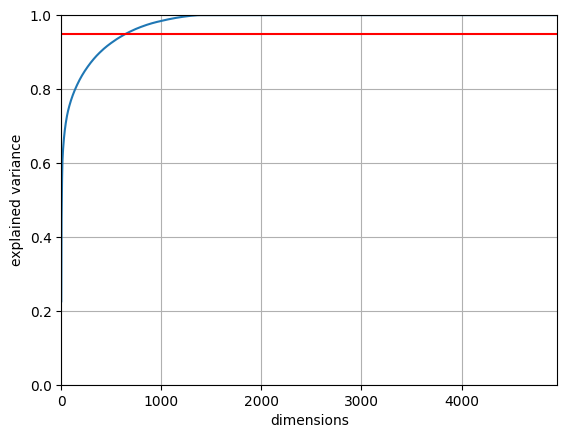

In [9]:
# PCA - check the 95% with figure
#
# This part is not necessary for the main process and
# can be commented out to save time
pca = PCA()
pca.fit(dataset_X)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.axis([0, dataset_X.shape[1], 0, 1]) 
plt.plot(pca_cumsum)
plt.axhline(y=0.95,color='red')
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [10]:
timer_start()

# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)
timer_read(return_time=False)

(10625, 650)
63.0s passed


### 2.7 Dataset split

In [11]:
# Split the dataset into training set and testing set
#
# `random_state` is specified for generating the same output between different runs after submitting
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, random_state=123456)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7968, 650)
(7968,)
(2657, 650)
(2657,)


## 3. Model Training

### 3.1 Logistic Regression

#### 3.1.1 Parameter Tuning

(This part is **not** necessary for generating the final result and can be commented out to save time)

In [12]:
# Define the model
lr = LogisticRegression(max_iter=10000)

# Search for the best C value using grid search CV
lr_param_grid = {
    'C': np.logspace(-2, 2, 5),
}
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', verbose=4)
lr_grid_search.fit(train_X, train_y)

# Print the best parameter and score
print("Best Parameter:    ", lr_grid_search.best_params_)
print("Score of the best: ", lr_grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ............................C=0.01;, score=0.826 total time=   0.1s
[CV 2/5] END ............................C=0.01;, score=0.806 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.809 total time=   0.1s
[CV 4/5] END ............................C=0.01;, score=0.814 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.790 total time=   0.1s
[CV 1/5] END .............................C=0.1;, score=0.875 total time=   0.2s
[CV 2/5] END .............................C=0.1;, score=0.869 total time=   0.3s
[CV 3/5] END .............................C=0.1;, score=0.870 total time=   0.3s
[CV 4/5] END .............................C=0.1;, score=0.883 total time=   0.3s
[CV 5/5] END .............................C=0.1;, score=0.862 total time=   0.2s
[CV 1/5] END .............................C=1.0;, score=0.885 total time=   0.8s
[CV 2/5] END .............................C=1.0;,

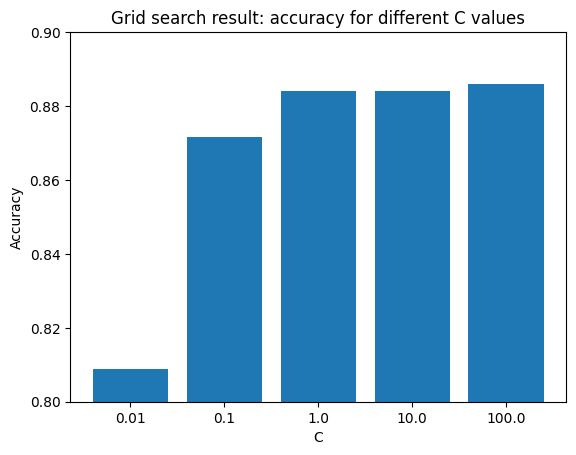

In [13]:
# Print the scores of all tested potential params
lr_grid_param_values = []
lr_grid_precision_values = []
for i, params in enumerate(lr_grid_search.cv_results_['params']):
    lr_grid_param_values.append(params['C'])
    lr_grid_precision_values.append(lr_grid_search.cv_results_['mean_test_score'][i])

# Plot the precision values for each parameter value
plt.bar(range(len(lr_grid_precision_values)), lr_grid_precision_values, tick_label=lr_grid_param_values)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])
plt.title('Grid search result: accuracy for different C values')
plt.show()

Based on the bar chart, scores for 1, 10 and 100 are close to each other with few differences. `C=1` is chosen with its high performance and the lowest time consumption between the three values, who is also the default value and a frequently used one in common practice,

#### 3.1.2 Model Training

In [14]:
timer_start()

lr = LogisticRegression(C=1.0, max_iter=1000)
lr.fit(train_X, train_y)

lr_train_time = timer_read()

1.11s passed


### 3.2 Support Vector Machine (SVM)

#### 3.2.1 Parameter Tuning

(This part is **not** necessary for generating the final result and can be commented out to save time)

In [15]:
# Grid_search for SVM
svm = SVC()
svm_param_grid = {
    'C': np.logspace(-2, 2, 5),
    'kernel':['linear','rbf','sigmoid']
}

svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', verbose=4)
svm_grid_search.fit(train_X, train_y)

# Print the best parameter and score
print("Best Parameter:    ", svm_grid_search.best_params_)
print("Score of the best: ", svm_grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.796 total time=   8.3s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.763 total time=   8.1s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.784 total time=   8.2s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.789 total time=   8.2s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.753 total time=   8.0s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.713 total time=  18.2s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.691 total time=  17.9s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.705 total time=  18.0s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.716 total time=  18.3s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.689 total time=  17.9s
[CV 1/5] END ............C=0.01, kernel=sigmoid;, score=0.738 total time=  16.4s
[CV 2/5] END ............C=0.01, kernel=sigmoid;

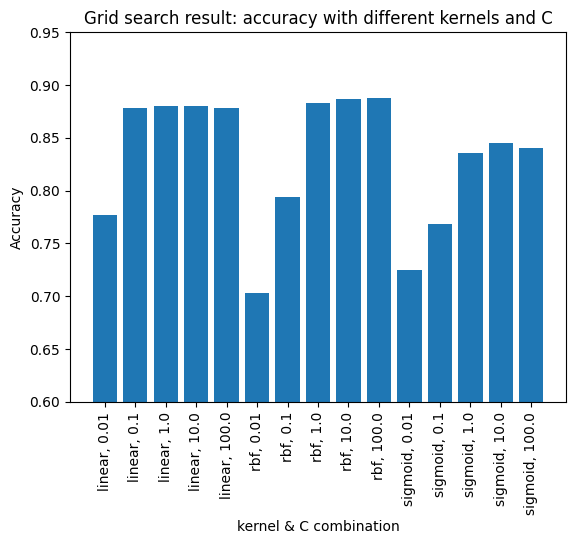

In [16]:
svm_grid_results = []
for i, params in enumerate(svm_grid_search.cv_results_['params']):
    svm_grid_results.append({
        "param": f"{params['kernel']}, {params['C']}",
        "score": svm_grid_search.cv_results_['mean_test_score'][i]
    })

# Sort the results by params
svm_grid_results = sorted(svm_grid_results, key=lambda a:a["param"])


# Plot the accuracy values for each parameter value
svm_grid_param_values = []
svm_grid_accuracy_values = []
for r in svm_grid_results:
    svm_grid_param_values.append(r["param"])
    svm_grid_accuracy_values.append(r["score"])

plt.bar(range(len(svm_grid_param_values)), svm_grid_accuracy_values, tick_label=svm_grid_param_values)
plt.xlabel('kernel & C combination')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.ylim([0.6, 0.95])
plt.title('Grid search result: accuracy with different kernels and C')
plt.show()

Based on the grid search result, `C=100` and `kernel="rbf"` is chosen for the SVM model with its best accuracy.

#### 3.2.2 Model Training

In [17]:
timer_start()

svm_model = SVC(kernel = 'rbf', C = 100)
svm_model.fit(train_X, train_y)

svm_train_time = timer_read()

5.9s passed


### 3.3 A Neural Network

#### 3.3.1 Data Proccess

A validation set is further splitted out from the original training set for the parameter tuning of the neural network.

In [18]:
keras.backend.clear_session()

temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y, uniques = pd.factorize(temp_train_y['country'], sort=True)
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y, random_state=114514, test_size=0.3)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)
print(uniques)

(5577, 650)
(2391, 650)
(5577, 3)
(2391, 3)
Index(['china', 'india', 'us'], dtype='object')


#### 3.3.2 Model Definition

In [19]:
def build_optimizer(hp):
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, step=1e-5)
    if optimizer == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    else:
        return keras.optimizers.SGD(learning_rate=lr, momentum=hp.Float('momentum', min_value=0, max_value=0.9, step=0.02))

def build_model(hp):
    model = keras.models.Sequential(keras.layers.InputLayer(input_shape=[train_X.shape[1]]))
    model.add(keras.layers.Dense(hp.Int('neurons', min_value=1, max_value=300, step=5),
                                 activation=hp.Choice('actv', ['relu', 'tanh', 'sigmoid']),
                                 kernel_initializer='he_normal'))

    model.add(keras.layers.Dense(3, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=build_optimizer(hp),
                  metrics=['accuracy'])
    return model

#### 3.3.3 Parameter Selection using Bayesion Optimization

In [20]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    project_name='neural_network_optimize'
)

tuner.search(x=train_X_nn, y=train_y_nn, epochs=20, validation_data=(validate_X, validate_y), batch_size=100)

best_hps = tuner.get_best_hyperparameters()[0]
print(f'Best hyperparameters: {best_hps.values}')

INFO:tensorflow:Reloading Tuner from .\neural_network_optimize\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'neurons': 281, 'actv': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00030000000000000003, 'momentum': 0.88}


#### 3.3.4 Model Trainning

In [21]:
timer_start()

optimized_model = build_model(best_hps)
history = optimized_model.fit(train_X_nn, train_y_nn, epochs=20,
                     validation_data=(validate_X, validate_y), batch_size=100)
optimized_model.summary()

nn_train_time = timer_read()

Epoch 1/20
56/56 [==============================] - 1s 6ms/step - loss: 0.9941 - accuracy: 0.6240 - val_loss: 0.8851 - val_accuracy: 0.7984
Epoch 2/20
56/56 [==============================] - 0s 3ms/step - loss: 0.7872 - accuracy: 0.8279 - val_loss: 0.7010 - val_accuracy: 0.8373
Epoch 3/20
56/56 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.8523 - val_loss: 0.5502 - val_accuracy: 0.8553
Epoch 4/20
56/56 [==============================] - 0s 4ms/step - loss: 0.4802 - accuracy: 0.8761 - val_loss: 0.4460 - val_accuracy: 0.8662
Epoch 5/20
56/56 [==============================] - 0s 3ms/step - loss: 0.3939 - accuracy: 0.8840 - val_loss: 0.3806 - val_accuracy: 0.8758
Epoch 6/20
56/56 [==============================] - 0s 3ms/step - loss: 0.3394 - accuracy: 0.8897 - val_loss: 0.3374 - val_accuracy: 0.8795
Epoch 7/20
56/56 [==============================] - 0s 3ms/step - loss: 0.3039 - accuracy: 0.8915 - val_loss: 0.3091 - val_accuracy: 0.8821
Epoch 8/20
56/56 [==

#### 3.3.5 Output of Model Training History

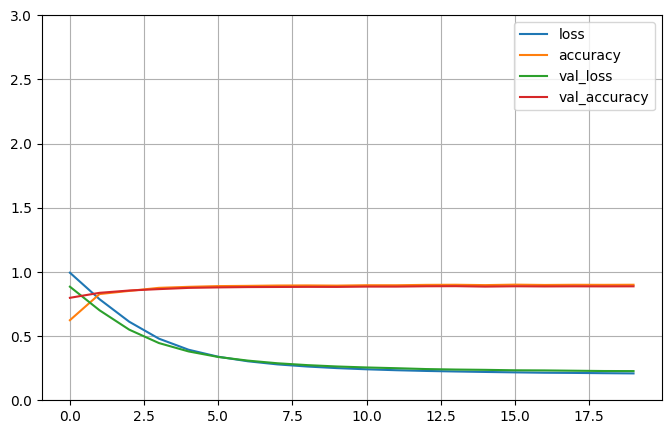

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## 4. Model Testing and Comparison

### 4.1 Test Results

#### 4.1.1 Logistic Regression

In [23]:
# Make prediction on the test set
timer_start()

lr_y_pred = lr.predict(test_X)

lr_test_time = timer_read()

0.0s passed


In [24]:
# Generate and save evaluation results

# Variable for storing the evaluation of logistic regression
lr_results={}

lr_results["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average='macro')
lr_results["recall"] = metrics.recall_score(test_y, lr_y_pred, average='macro')
lr_results["precision"] = metrics.precision_score(test_y, lr_y_pred, average='macro')
lr_results["accuracy"] = metrics.accuracy_score(test_y, lr_y_pred)

lr_results["by_label"] = {}
lr_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))  # for metric functions, all labels are used in sorted order
lr_results["by_label"]["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["recall"] = metrics.recall_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["precision"] = metrics.precision_score(test_y, lr_y_pred, average=None)

# Print formatted classification report
print(metrics.classification_report(test_y, lr_y_pred))

# Check the result dict
print()
print(lr_results)

              precision    recall  f1-score   support

       china       0.99      0.90      0.94       783
       india       0.80      0.99      0.88      1021
          us       0.97      0.77      0.86       853

    accuracy                           0.89      2657
   macro avg       0.92      0.89      0.89      2657
weighted avg       0.91      0.89      0.89      2657


{'f1_score': 0.8943782402425424, 'recall': 0.8862786634498686, 'precision': 0.9177243469954429, 'accuracy': 0.8923598042905533, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94109772, 0.882662  , 0.859375  ]), 'recall': array([0.89782886, 0.98726738, 0.77373974]), 'precision': array([0.98874824, 0.79809976, 0.96632504])}}


#### 4.1.2 Support Vector Machine (SVM)

In [25]:
# Make prediction
timer_start()

svm_y_pred = svm_model.predict(test_X)

svm_test_time = timer_read()

2.68s passed


In [26]:
# Evaluate the prediction
svm_results={}

svm_results["f1_score"] = metrics.f1_score(test_y, svm_y_pred, average='macro')
svm_results["recall"] = metrics.recall_score(test_y, svm_y_pred, average='macro')
svm_results["precision"] = metrics.precision_score(test_y, svm_y_pred, average='macro')
svm_results["accuracy"] = metrics.accuracy_score(test_y, svm_y_pred)

svm_results["by_label"] = {}
svm_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))
svm_results["by_label"]["f1_score"] = metrics.f1_score(test_y, svm_y_pred, average=None)
svm_results["by_label"]["recall"] = metrics.recall_score(test_y, svm_y_pred, average=None)
svm_results["by_label"]["precision"] = metrics.precision_score(test_y, svm_y_pred, average=None)

# Print formatted classification report
print(metrics.classification_report(test_y, svm_y_pred))

# Check the result dict
print(svm_results)

              precision    recall  f1-score   support

       china       0.99      0.90      0.94       783
       india       0.80      0.99      0.89      1021
          us       0.97      0.78      0.87       853

    accuracy                           0.90      2657
   macro avg       0.92      0.89      0.90      2657
weighted avg       0.91      0.90      0.90      2657

{'f1_score': 0.8975676028201737, 'recall': 0.8893399894076407, 'precision': 0.9213144035345174, 'accuracy': 0.8957470831765149, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.93967828, 0.88713911, 0.86588542]), 'recall': array([0.89527458, 0.99314398, 0.77960141]), 'precision': array([0.9887165 , 0.80158103, 0.97364568])}}


#### 4.1.3 The Neural Network

In [27]:
timer_start()

# Test on the test set
nn_y_pred = optimized_model.predict(test_X)
nn_y_pred = np.argmax(nn_y_pred, axis=1)
nn_y_pred = nn_y_pred.astype(np.unicode_)
print(nn_y_pred)

for i in range(len(uniques)):
    n1 = str(i)
    n2 = uniques[i]
    index = (nn_y_pred == n1)
    nn_y_pred[index] = n2

nn_test_time = timer_read()

84/84 [==============================] - 0s 2ms/step
['2' '1' '1' ... '2' '0' '2']
0.281s passed


In [28]:
# Evaluate the result
nn_results={}

nn_results["f1_score"] = metrics.f1_score(test_y, nn_y_pred, average='macro')
nn_results["recall"] = metrics.recall_score(test_y, nn_y_pred, average='macro')
nn_results["precision"] = metrics.precision_score(test_y, nn_y_pred, average='macro')
nn_results["accuracy"] = metrics.accuracy_score(test_y, nn_y_pred)

nn_results["by_label"] = {}
nn_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))
nn_results["by_label"]["f1_score"] = metrics.f1_score(test_y, nn_y_pred, average=None)
nn_results["by_label"]["recall"] = metrics.recall_score(test_y, nn_y_pred, average=None)
nn_results["by_label"]["precision"] = metrics.precision_score(test_y, nn_y_pred, average=None)

print(metrics.classification_report(test_y, nn_y_pred))
print(nn_results)

              precision    recall  f1-score   support

       china       0.98      0.90      0.94       783
       india       0.86      0.90      0.88      1021
          us       0.85      0.86      0.85       853

    accuracy                           0.89      2657
   macro avg       0.90      0.89      0.89      2657
weighted avg       0.89      0.89      0.89      2657

{'f1_score': 0.8922614403419629, 'recall': 0.8889855490959437, 'precision': 0.8970393809545131, 'accuracy': 0.889348889725254, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94274301, 0.88038278, 0.85365854]), 'recall': array([0.90421456, 0.90107738, 0.86166471]), 'precision': array([0.98470097, 0.8606174 , 0.84579977])}}


In [29]:
###################################
# TODO Comparsion testing used    #
# REMOVE IT                       #
###################################
# nn_results = {
#     'f1_score': 0.9007197889398685, 
#     'recall': 0.893005095965005, 
#     'precision': 0.9225999568649534, 
#     'accuracy': 0.8980052691004893, 
#     'by_label': {
#         'labels': np.array(['china', 'india', 'us']), 
#         'f1_score': np.array([0.94291471, 0.88456435, 0.87468031]), 
#         'recall': np.array([0.90115533, 0.98619329, 0.79166667]), 
#         'precision': np.array([0.98873239, 0.80192462, 0.97714286])
#     }
# }
# nn_train_time = 0
# nn_test_time = 0.248
# print("MOCK NN RESULT USED")

### 4.2 Result Comparison

#### 4.2.1 Overall Results

##### (a) time consumption

Time consumption (second)

                Training  Testing
Logistic Reg        1.11     0.00
SVM                 5.90     2.68
Neural Network      5.62     0.28


C:\Users\EricTan\AppData\Local\Temp\ipykernel_24452\3299566582.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


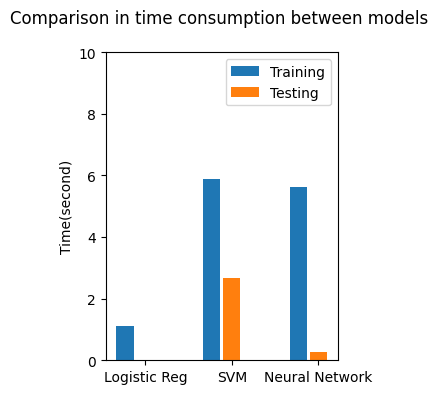

In [30]:
time_stat = pd.DataFrame({
    "Training": [
        lr_train_time,
        svm_train_time,
        nn_train_time
    ],
    "Testing": [
        lr_test_time,
        svm_test_time,
        nn_test_time
    ]
}, index=["Logistic Reg", "SVM", "Neural Network"])

pd.options.display.float_format = '{:.2f}'.format

print("Time consumption (second)")
print()
print(time_stat)

# bar plot
bar_width=0.2
bar_group_margin=0.3
bar_margin=(1 - bar_group_margin - bar_width * 3) / 3

plt.subplots(figsize=(9, 4))
plt.subplots_adjust(right=1)

plt.subplot(1, 3, 1)
plt.title("Comparison in time consumption between models \n")
plt.bar(
    np.arange(3) - bar_width - bar_margin,
    time_stat['Training']
    , label="Training", width=bar_width
)
plt.bar(
    np.arange(3),
    time_stat['Testing'],
    label="Testing", width=bar_width
)

bar_names=time_stat.index
plt.xticks(np.arange(3), bar_names)
plt.ylabel('Time(second)')
plt.ylim([0, 10])
plt.legend()

##### (b) accuracy

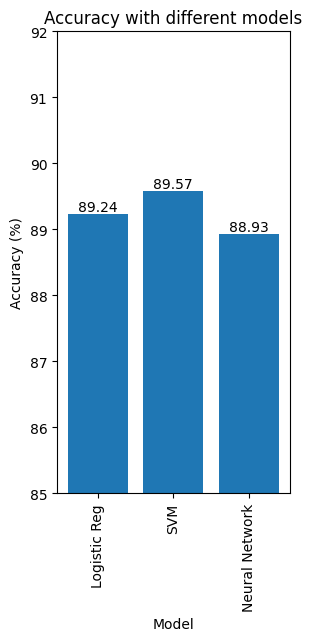

In [31]:
# Print the accuracy comparsion
plt.figure(figsize=(3, 6))
plt.bar_label(
    plt.bar(
        range(3), 
        [lr_results["accuracy"] * 100, svm_results["accuracy"] * 100, nn_results["accuracy"] * 100], 
        tick_label=["Logistic Reg", "SVM", "Neural Network"]
    ),
    fmt="%.2f"
)
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Accuracy (%)')
plt.ylim([85, 92])
plt.title('Accuracy with different models')
plt.show()

##### (c) precision, recall and F1 score

C:\Users\EricTan\AppData\Local\Temp\ipykernel_24452\2451151969.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


(0.85, 0.95)

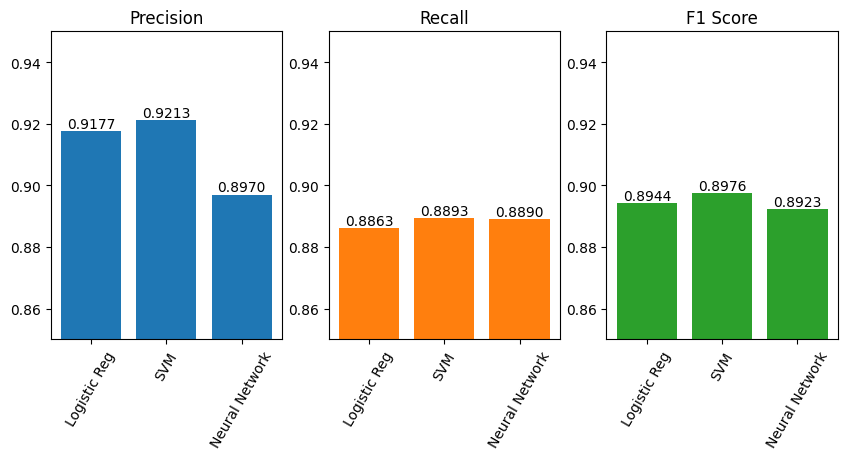

In [32]:
# Print the comparsion with other measures
plt.subplots(figsize=(9, 4))
plt.subplots_adjust(right=1)

plt.subplot(1, 3, 1)
plt.bar_label(
    plt.bar(
        range(3), 
        [lr_results["precision"], svm_results["precision"], nn_results["precision"]], 
        tick_label=["Logistic Reg", "SVM", "Neural Network"]
    ),
    fmt="%.4f"
)
plt.title('Precision')
plt.xticks(rotation=60)
plt.ylim([0.85, 0.95])

plt.subplot(1, 3, 2)
plt.bar_label(
    plt.bar(
        range(3), 
        [lr_results["recall"], svm_results["recall"], nn_results["recall"]], 
        tick_label=["Logistic Reg", "SVM", "Neural Network"],
        color="#ff7f0e"
    ),
    fmt="%.4f"
)
plt.title('Recall')
plt.xticks(rotation=60)
plt.ylim([0.85, 0.95])

plt.subplot(1, 3, 3)
plt.bar_label(
    plt.bar(
        range(3), 
        [lr_results["f1_score"], svm_results["f1_score"], nn_results["f1_score"]], 
        tick_label=["Logistic Reg", "SVM", "Neural Network"],
        color="#2ca02c"
    ),
    fmt="%.4f"
)
plt.title('F1 Score')
plt.xticks(rotation=60)
plt.ylim([0.85, 0.95])

#### 4.2.2 Category-based Comparison

##### performance within different categories

C:\Users\EricTan\AppData\Local\Temp\ipykernel_24452\1053457287.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


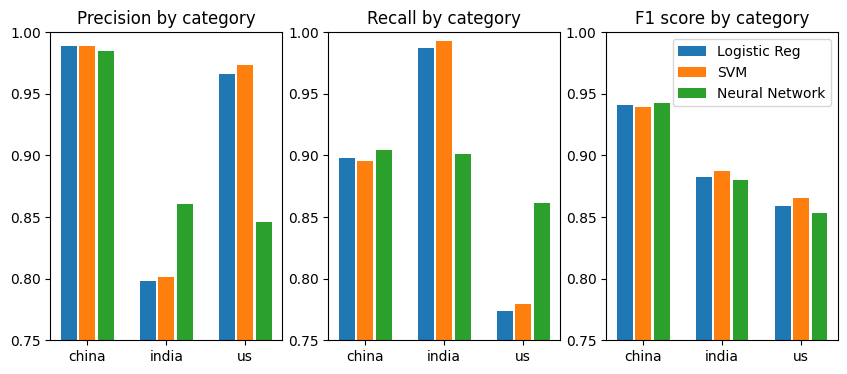

In [33]:
# Compare between categories
bar_width=0.2
bar_group_margin=0.3
bar_margin=(1 - bar_group_margin - bar_width * 3) / 3

plt.subplots(figsize=(9, 4))
plt.subplots_adjust(right=1)

# Draw bars for precision on diffierent categories
plt.subplot(1, 3, 1)
plt.title("Precision by category")
plt.bar(
    np.arange(3) - bar_width - bar_margin, [
        lr_results["by_label"]["precision"][0],
        lr_results["by_label"]["precision"][1],
        lr_results["by_label"]["precision"][2],
    ], label="Logistic Reg", width=bar_width
)
plt.bar(
    np.arange(3), [
        svm_results["by_label"]["precision"][0],
        svm_results["by_label"]["precision"][1],
        svm_results["by_label"]["precision"][2],
    ], label="SVM", width=bar_width
)
plt.bar(
    np.arange(3) + bar_width + bar_margin, [
        nn_results["by_label"]["precision"][0],
        nn_results["by_label"]["precision"][1],
        nn_results["by_label"]["precision"][2],
    ], label="Neural Network", width=bar_width
)

bar_names=lr_results["by_label"]["labels"]
plt.xticks(np.arange(3), bar_names)
plt.ylim([0.75, 1])


# Draw bars for recall on diffierent categories
plt.subplot(1, 3, 2)
plt.title("Recall by category")
plt.bar(
    np.arange(3) - bar_width - bar_margin, [
        lr_results["by_label"]["recall"][0],
        lr_results["by_label"]["recall"][1],
        lr_results["by_label"]["recall"][2],
    ], label="Logistic Reg", width=bar_width
)
plt.bar(
    np.arange(3), [
        svm_results["by_label"]["recall"][0],
        svm_results["by_label"]["recall"][1],
        svm_results["by_label"]["recall"][2],
    ], label="SVM", width=bar_width
)
plt.bar(
    np.arange(3) + bar_width + bar_margin, [
        nn_results["by_label"]["recall"][0],
        nn_results["by_label"]["recall"][1],
        nn_results["by_label"]["recall"][2],
    ], label="Neural Network", width=bar_width
)

bar_names=lr_results["by_label"]["labels"]
plt.xticks(np.arange(3), bar_names)
plt.ylim([0.75, 1])


# Draw bars for F1 score on diffierent categories
plt.subplot(1, 3, 3)
plt.title("F1 score by category")
plt.bar(
    np.arange(3) - bar_width - bar_margin, [
        lr_results["by_label"]["f1_score"][0],
        lr_results["by_label"]["f1_score"][1],
        lr_results["by_label"]["f1_score"][2],
    ], label="Logistic Reg", width=bar_width
)
plt.bar(
    np.arange(3), [
        svm_results["by_label"]["f1_score"][0],
        svm_results["by_label"]["f1_score"][1],
        svm_results["by_label"]["f1_score"][2],
    ], label="SVM", width=bar_width
)
plt.bar(
    np.arange(3) + bar_width + bar_margin, [
        nn_results["by_label"]["f1_score"][0],
        nn_results["by_label"]["f1_score"][1],
        nn_results["by_label"]["f1_score"][2],
    ], label="Neural Network", width=bar_width
)

bar_names=lr_results["by_label"]["labels"]
plt.xticks(np.arange(3), bar_names)
plt.ylim([0.75, 1])
plt.legend()

#### 4.2.3 Dataset Analysis

##### (a) number of samples with different labels

Text(0.5, 1.0, 'Sample number by category')

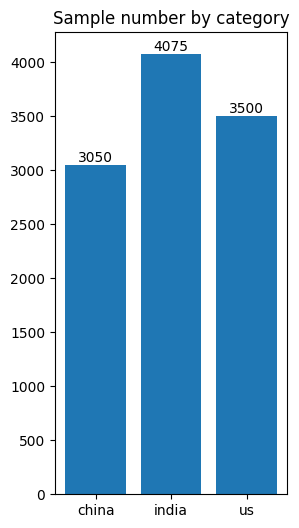

In [34]:
# Number of samples with different category in the dataset
num_of_samples = {
    "china": np.count_nonzero(dataset_y == "china"),
    "india": np.count_nonzero(dataset_y == "india"),
    "us": np.count_nonzero(dataset_y == "us")
}

plt.figure(figsize=(3, 6))
plt.bar_label(plt.bar(
    range(3), [
        num_of_samples["china"],
        num_of_samples["india"],
        num_of_samples["us"],
    ], tick_label=["china", "india", "us"]
))
plt.title('Sample number by category')


##### (b) number of distinct raw features in categories

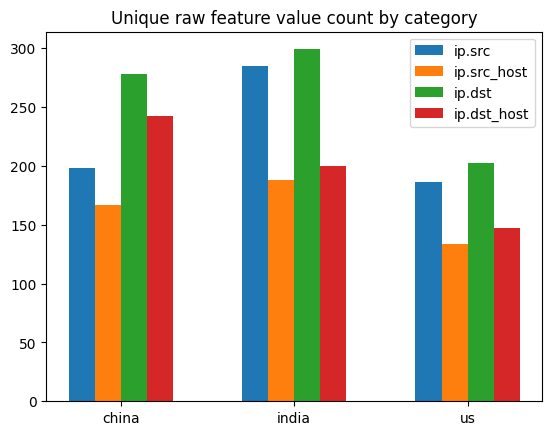

In [35]:
# Check raw feature variance within different data groups

# Find sample indexes by label
label_i = {
    "china": np.where(dataset_y == "china"),
    "india": np.where(dataset_y == "india"),
    "us": np.where(dataset_y == "us"),
}
# Count number of raw feature values within categories
def count_distinct(checked_array):
    return {
        "china": len(np.unique(np.take(checked_array, label_i["china"]))),
        "india": len(np.unique(np.take(checked_array, label_i["india"]))),
        "us": len(np.unique(np.take(checked_array, label_i["us"]))),
    }
num_of_distinct = {
    "ip_src": count_distinct(dataset_X_ip_src),
    "ip_src_host": count_distinct(dataset_X_ip_src_host),
    "ip_dst": count_distinct(dataset_X_ip_dst),
    "ip_dst_host": count_distinct(dataset_X_ip_dst_host),
}


# Draw chart for printing the result
bar_width=0.15
bar_group_margin=0.4
bar_margin=(1 - bar_group_margin - bar_width * 4) / 4

# Draw bars for precision on diffierent categories
plt.title("Unique raw feature value count by category")
plt.bar(
    np.arange(3) - bar_width * 1.5 - bar_margin * 1.5, [
        num_of_distinct["ip_src"]["china"],
        num_of_distinct["ip_src"]["india"],
        num_of_distinct["ip_src"]["us"]
    ], label="ip.src", width=bar_width
)
plt.bar(
    np.arange(3) - bar_width * 0.5 - bar_margin * 0.5, [
        num_of_distinct["ip_src_host"]["china"],
        num_of_distinct["ip_src_host"]["india"],
        num_of_distinct["ip_src_host"]["us"]
    ], label="ip.src_host", width=bar_width
)
plt.bar(
    np.arange(3) + bar_width * 0.5 + bar_margin * 0.5, [
        num_of_distinct["ip_dst"]["china"],
        num_of_distinct["ip_dst"]["india"],
        num_of_distinct["ip_dst"]["us"]
    ], label="ip.dst", width=bar_width
)
plt.bar(
    np.arange(3) + bar_width * 1.5 + bar_margin * 1.5, [
        num_of_distinct["ip_dst_host"]["china"],
        num_of_distinct["ip_dst_host"]["india"],
        num_of_distinct["ip_dst_host"]["us"]
    ], label="ip.dst_host", width=bar_width
)

bar_names=["china", "india", "us"]
plt.xticks(np.arange(3), bar_names)
plt.legend()